In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.preprocessing import StandardScaler, MaxAbsScaler 
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchdiffeq import odeint

N_X_FEATURES = 7  
N_U_FEATURES = 2  
DEVICE = torch.device("cuda" if torch.cuda.is_available() else  "cpu")

print(f"Using device: {DEVICE}")

data_dir = "Data/CMG/train"
X_flat = np.load(f'{data_dir}/Xdata.npy')
XP_flat = np.load(f'{data_dir}/XPdata.npy')
U_flat = np.load(f'{data_dir}/Udata.npy')


SEQ_LEN_TEST = 5000
X_train, X_test = X_flat[:-SEQ_LEN_TEST,:N_X_FEATURES], X_flat[-SEQ_LEN_TEST:,:N_X_FEATURES]
U_train, U_test = U_flat[:-SEQ_LEN_TEST], U_flat[-SEQ_LEN_TEST:]
XP_train, XP_test = XP_flat[:-SEQ_LEN_TEST,:N_X_FEATURES], XP_flat[-SEQ_LEN_TEST:,:N_X_FEATURES]

scaler_x = StandardScaler()
scaler_u = StandardScaler()

X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
XP_train_scaled = scaler_x.transform(XP_train)
XP_test_scaled = scaler_x.transform(XP_test)

U_train_scaled = scaler_u.fit_transform(U_train)
U_test_scaled = scaler_u.transform(U_test)

class SingleStepDataset(Dataset):
    def __init__(self, x_data, u_data, xp_data):
        self.x = torch.from_numpy(x_data).float()
        self.u = torch.from_numpy(u_data).float()
        self.xp = torch.from_numpy(xp_data).float()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.u[idx], self.xp[idx]

train_dataset = SingleStepDataset(X_train_scaled, U_train_scaled, XP_train_scaled)
test_dataset = SingleStepDataset(X_test_scaled, U_test_scaled, XP_test_scaled)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

import joblib
joblib.dump(scaler_x, 'scaler_x.joblib')
joblib.dump(scaler_u, 'scaler_u.joblib')
print("Scalers have been saved.")



Using device: cpu
Scalers have been saved.


In [2]:

class ODEDynamics(nn.Module):
    def __init__(self, x_dim, u_dim, hidden_dim=512):
        super(ODEDynamics, self).__init__()
        # 神经网络用于逼近 f
        self.net = nn.Sequential(
            nn.Linear(x_dim + u_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, x_dim),
        )

    def forward(self, t, state_and_control):
        # 将状态 x 和控制 u 分离
        x, u = state_and_control
        # 将 x 和 u 拼接作为网络输入
        xu = torch.cat([x, u], dim=1)
        return self.net(xu)



class NeuralODE(nn.Module):
    def __init__(self, dynamics_func, solver='dopri5', rtol=1e-5, atol=1e-5):
        super(NeuralODE, self).__init__()
        self.dynamics_func = dynamics_func
        self.solver = solver
        self.rtol = rtol
        self.atol = atol

    def forward(self, x0, u, t_span):
        def wrapped_dynamics(t, x):
            return self.dynamics_func(t, (x, u))
        pred_x = odeint(wrapped_dynamics, x0, t_span,
                        method=self.solver, rtol=self.rtol, atol=self.atol)
        return pred_x[-1]


In [ ]:
def train_model(model, train_loader, test_loader, num_epochs=100, learning_rate=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()
    best_test_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for x, u, xp in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            x, u, xp = x.to(DEVICE), u.to(DEVICE), xp.to(DEVICE)
            optimizer.zero_grad()
            t_span = torch.tensor([0.0, 0.01]).to(DEVICE)
            pred_xp = model(x, u, t_span)
            loss = criterion(pred_xp, xp)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * x.size(0)

        train_loss /= len(train_loader.dataset)

        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for x, u, xp in test_loader:
                x, u, xp = x.to(DEVICE), u.to(DEVICE), xp.to(DEVICE)
                t_span = torch.tensor([0.0, 0.01]).to(DEVICE)
                pred_xp = model(x, u, t_span)
                loss = criterion(pred_xp, xp)
                test_loss += loss.item() * x.size(0)

        test_loss /= len(test_loader.dataset)

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            # Save the best model
            torch.save(model.state_dict(), "NeuralODE_512.pth")

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")  


dynamics_func = ODEDynamics(x_dim=N_X_FEATURES, u_dim=N_U_FEATURES).to(DEVICE)
neural_ode_model = NeuralODE(dynamics_func).to(DEVICE)
train_model(neural_ode_model, train_loader, test_loader, learning_rate=1e-3)  

Epoch 1/100: 100%|██████████| 1524/1524 [00:23<00:00, 63.81it/s]


Epoch 1/100, Train Loss: 0.000588, Test Loss: 0.000030


Epoch 2/100: 100%|██████████| 1524/1524 [00:20<00:00, 76.03it/s] 


Epoch 2/100, Train Loss: 0.000067, Test Loss: 0.000018


Epoch 3/100: 100%|██████████| 1524/1524 [00:12<00:00, 123.91it/s]


Epoch 3/100, Train Loss: 0.000035, Test Loss: 0.000016


Epoch 4/100: 100%|██████████| 1524/1524 [00:12<00:00, 123.39it/s]


Epoch 4/100, Train Loss: 0.000026, Test Loss: 0.000012


Epoch 5/100: 100%|██████████| 1524/1524 [00:13<00:00, 114.43it/s]


Epoch 5/100, Train Loss: 0.000021, Test Loss: 0.000008


Epoch 6/100: 100%|██████████| 1524/1524 [00:15<00:00, 100.53it/s]


Epoch 6/100, Train Loss: 0.000019, Test Loss: 0.000008


Epoch 7/100: 100%|██████████| 1524/1524 [00:13<00:00, 109.20it/s]


Epoch 7/100, Train Loss: 0.000017, Test Loss: 0.000029


Epoch 8/100: 100%|██████████| 1524/1524 [00:13<00:00, 112.34it/s]


Epoch 8/100, Train Loss: 0.000016, Test Loss: 0.000007


Epoch 9/100: 100%|██████████| 1524/1524 [00:28<00:00, 53.41it/s]


Epoch 9/100, Train Loss: 0.000016, Test Loss: 0.000007


Epoch 10/100: 100%|██████████| 1524/1524 [01:06<00:00, 22.81it/s]


Epoch 10/100, Train Loss: 0.000014, Test Loss: 0.000007


Epoch 11/100: 100%|██████████| 1524/1524 [00:28<00:00, 53.35it/s]


Epoch 11/100, Train Loss: 0.000014, Test Loss: 0.000006


Epoch 12/100: 100%|██████████| 1524/1524 [00:41<00:00, 37.00it/s]


Epoch 12/100, Train Loss: 0.000013, Test Loss: 0.000005


Epoch 13/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.27it/s]


Epoch 13/100, Train Loss: 0.000013, Test Loss: 0.000005


Epoch 14/100: 100%|██████████| 1524/1524 [00:27<00:00, 55.05it/s]


Epoch 14/100, Train Loss: 0.000012, Test Loss: 0.000005


Epoch 15/100: 100%|██████████| 1524/1524 [00:24<00:00, 62.97it/s]


Epoch 15/100, Train Loss: 0.000013, Test Loss: 0.000010


Epoch 16/100: 100%|██████████| 1524/1524 [00:28<00:00, 53.91it/s]


Epoch 16/100, Train Loss: 0.000012, Test Loss: 0.000005


Epoch 17/100: 100%|██████████| 1524/1524 [00:26<00:00, 58.40it/s]


Epoch 17/100, Train Loss: 0.000011, Test Loss: 0.000009


Epoch 18/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.65it/s]


Epoch 18/100, Train Loss: 0.000012, Test Loss: 0.000005


Epoch 19/100: 100%|██████████| 1524/1524 [00:23<00:00, 64.39it/s]


Epoch 19/100, Train Loss: 0.000011, Test Loss: 0.000005


Epoch 20/100: 100%|██████████| 1524/1524 [00:28<00:00, 54.20it/s]


Epoch 20/100, Train Loss: 0.000011, Test Loss: 0.000004


Epoch 21/100: 100%|██████████| 1524/1524 [00:32<00:00, 46.67it/s]


Epoch 21/100, Train Loss: 0.000011, Test Loss: 0.000005


Epoch 22/100: 100%|██████████| 1524/1524 [00:21<00:00, 69.56it/s]


Epoch 22/100, Train Loss: 0.000010, Test Loss: 0.000005


Epoch 23/100: 100%|██████████| 1524/1524 [00:26<00:00, 56.95it/s]


Epoch 23/100, Train Loss: 0.000011, Test Loss: 0.000005


Epoch 24/100: 100%|██████████| 1524/1524 [00:35<00:00, 43.35it/s]


Epoch 24/100, Train Loss: 0.000010, Test Loss: 0.000007


Epoch 25/100: 100%|██████████| 1524/1524 [00:34<00:00, 44.32it/s]


Epoch 25/100, Train Loss: 0.000009, Test Loss: 0.000004


Epoch 26/100: 100%|██████████| 1524/1524 [00:27<00:00, 56.31it/s]


Epoch 26/100, Train Loss: 0.000009, Test Loss: 0.000003


Epoch 27/100: 100%|██████████| 1524/1524 [00:33<00:00, 45.15it/s]


Epoch 27/100, Train Loss: 0.000009, Test Loss: 0.000004


Epoch 28/100: 100%|██████████| 1524/1524 [00:26<00:00, 56.52it/s]


Epoch 28/100, Train Loss: 0.000009, Test Loss: 0.000006


Epoch 29/100: 100%|██████████| 1524/1524 [00:41<00:00, 36.95it/s]


Epoch 29/100, Train Loss: 0.000009, Test Loss: 0.000006


Epoch 30/100: 100%|██████████| 1524/1524 [00:43<00:00, 34.83it/s]


Epoch 30/100, Train Loss: 0.000009, Test Loss: 0.000005


Epoch 31/100: 100%|██████████| 1524/1524 [00:33<00:00, 45.04it/s]


Epoch 31/100, Train Loss: 0.000009, Test Loss: 0.000009


Epoch 32/100: 100%|██████████| 1524/1524 [00:37<00:00, 41.15it/s]


Epoch 32/100, Train Loss: 0.000008, Test Loss: 0.000004


Epoch 33/100: 100%|██████████| 1524/1524 [00:36<00:00, 41.76it/s]


Epoch 33/100, Train Loss: 0.000009, Test Loss: 0.000005


Epoch 34/100: 100%|██████████| 1524/1524 [00:40<00:00, 37.80it/s]


Epoch 34/100, Train Loss: 0.000009, Test Loss: 0.000008


Epoch 35/100: 100%|██████████| 1524/1524 [00:28<00:00, 52.67it/s]


Epoch 35/100, Train Loss: 0.000009, Test Loss: 0.000004


Epoch 36/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.13it/s]


Epoch 36/100, Train Loss: 0.000008, Test Loss: 0.000004


Epoch 37/100: 100%|██████████| 1524/1524 [00:33<00:00, 45.76it/s]


Epoch 37/100, Train Loss: 0.000008, Test Loss: 0.000005


Epoch 38/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.51it/s]


Epoch 38/100, Train Loss: 0.000009, Test Loss: 0.000005


Epoch 39/100: 100%|██████████| 1524/1524 [00:37<00:00, 40.11it/s]


Epoch 39/100, Train Loss: 0.000008, Test Loss: 0.000004


Epoch 40/100: 100%|██████████| 1524/1524 [00:33<00:00, 46.06it/s]


Epoch 40/100, Train Loss: 0.000008, Test Loss: 0.000006


Epoch 41/100: 100%|██████████| 1524/1524 [00:33<00:00, 45.18it/s]


Epoch 41/100, Train Loss: 0.000008, Test Loss: 0.000007


Epoch 42/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.15it/s]


Epoch 42/100, Train Loss: 0.000007, Test Loss: 0.000005


Epoch 43/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.24it/s]


Epoch 43/100, Train Loss: 0.000008, Test Loss: 0.000005


Epoch 44/100: 100%|██████████| 1524/1524 [00:31<00:00, 49.14it/s]


Epoch 44/100, Train Loss: 0.000007, Test Loss: 0.000005


Epoch 45/100: 100%|██████████| 1524/1524 [00:29<00:00, 52.50it/s]


Epoch 45/100, Train Loss: 0.000008, Test Loss: 0.000005


Epoch 46/100: 100%|██████████| 1524/1524 [00:29<00:00, 51.87it/s]


Epoch 46/100, Train Loss: 0.000007, Test Loss: 0.000004


Epoch 47/100: 100%|██████████| 1524/1524 [00:33<00:00, 45.97it/s]


Epoch 47/100, Train Loss: 0.000007, Test Loss: 0.000004


Epoch 48/100: 100%|██████████| 1524/1524 [00:31<00:00, 48.65it/s]


Epoch 48/100, Train Loss: 0.000007, Test Loss: 0.000005


Epoch 49/100: 100%|██████████| 1524/1524 [00:30<00:00, 50.72it/s]


Epoch 49/100, Train Loss: 0.000007, Test Loss: 0.000005


Epoch 50/100: 100%|██████████| 1524/1524 [00:26<00:00, 56.85it/s]


Epoch 50/100, Train Loss: 0.000008, Test Loss: 0.000004


Epoch 51/100: 100%|██████████| 1524/1524 [00:28<00:00, 53.74it/s]


Epoch 51/100, Train Loss: 0.000006, Test Loss: 0.000004


Epoch 52/100: 100%|██████████| 1524/1524 [00:21<00:00, 70.48it/s]


Epoch 52/100, Train Loss: 0.000007, Test Loss: 0.000004


Epoch 53/100: 100%|██████████| 1524/1524 [00:26<00:00, 58.02it/s]


Epoch 53/100, Train Loss: 0.000007, Test Loss: 0.000004


Epoch 54/100: 100%|██████████| 1524/1524 [00:27<00:00, 55.98it/s]


Epoch 54/100, Train Loss: 0.000007, Test Loss: 0.000003


Epoch 55/100: 100%|██████████| 1524/1524 [00:27<00:00, 55.46it/s]


Epoch 55/100, Train Loss: 0.000007, Test Loss: 0.000003


Epoch 56/100: 100%|██████████| 1524/1524 [00:26<00:00, 58.06it/s]


Epoch 56/100, Train Loss: 0.000007, Test Loss: 0.000004


Epoch 57/100: 100%|██████████| 1524/1524 [00:27<00:00, 56.38it/s]


Epoch 57/100, Train Loss: 0.000006, Test Loss: 0.000003


Epoch 58/100: 100%|██████████| 1524/1524 [00:28<00:00, 52.65it/s]


Epoch 58/100, Train Loss: 0.000007, Test Loss: 0.000007


Epoch 59/100: 100%|██████████| 1524/1524 [00:22<00:00, 67.76it/s]


Epoch 59/100, Train Loss: 0.000006, Test Loss: 0.000004


Epoch 60/100: 100%|██████████| 1524/1524 [00:21<00:00, 72.38it/s]


Epoch 60/100, Train Loss: 0.000006, Test Loss: 0.000003


Epoch 61/100: 100%|██████████| 1524/1524 [00:23<00:00, 64.55it/s]


Epoch 61/100, Train Loss: 0.000006, Test Loss: 0.000004


Epoch 62/100: 100%|██████████| 1524/1524 [00:21<00:00, 70.20it/s]


Epoch 62/100, Train Loss: 0.000006, Test Loss: 0.000004


Epoch 63/100:  73%|███████▎  | 1117/1524 [00:16<00:07, 53.60it/s]


--- testing  ---

[Neural ODE] 10 step recursion prediction MSE = 2.952856e-01


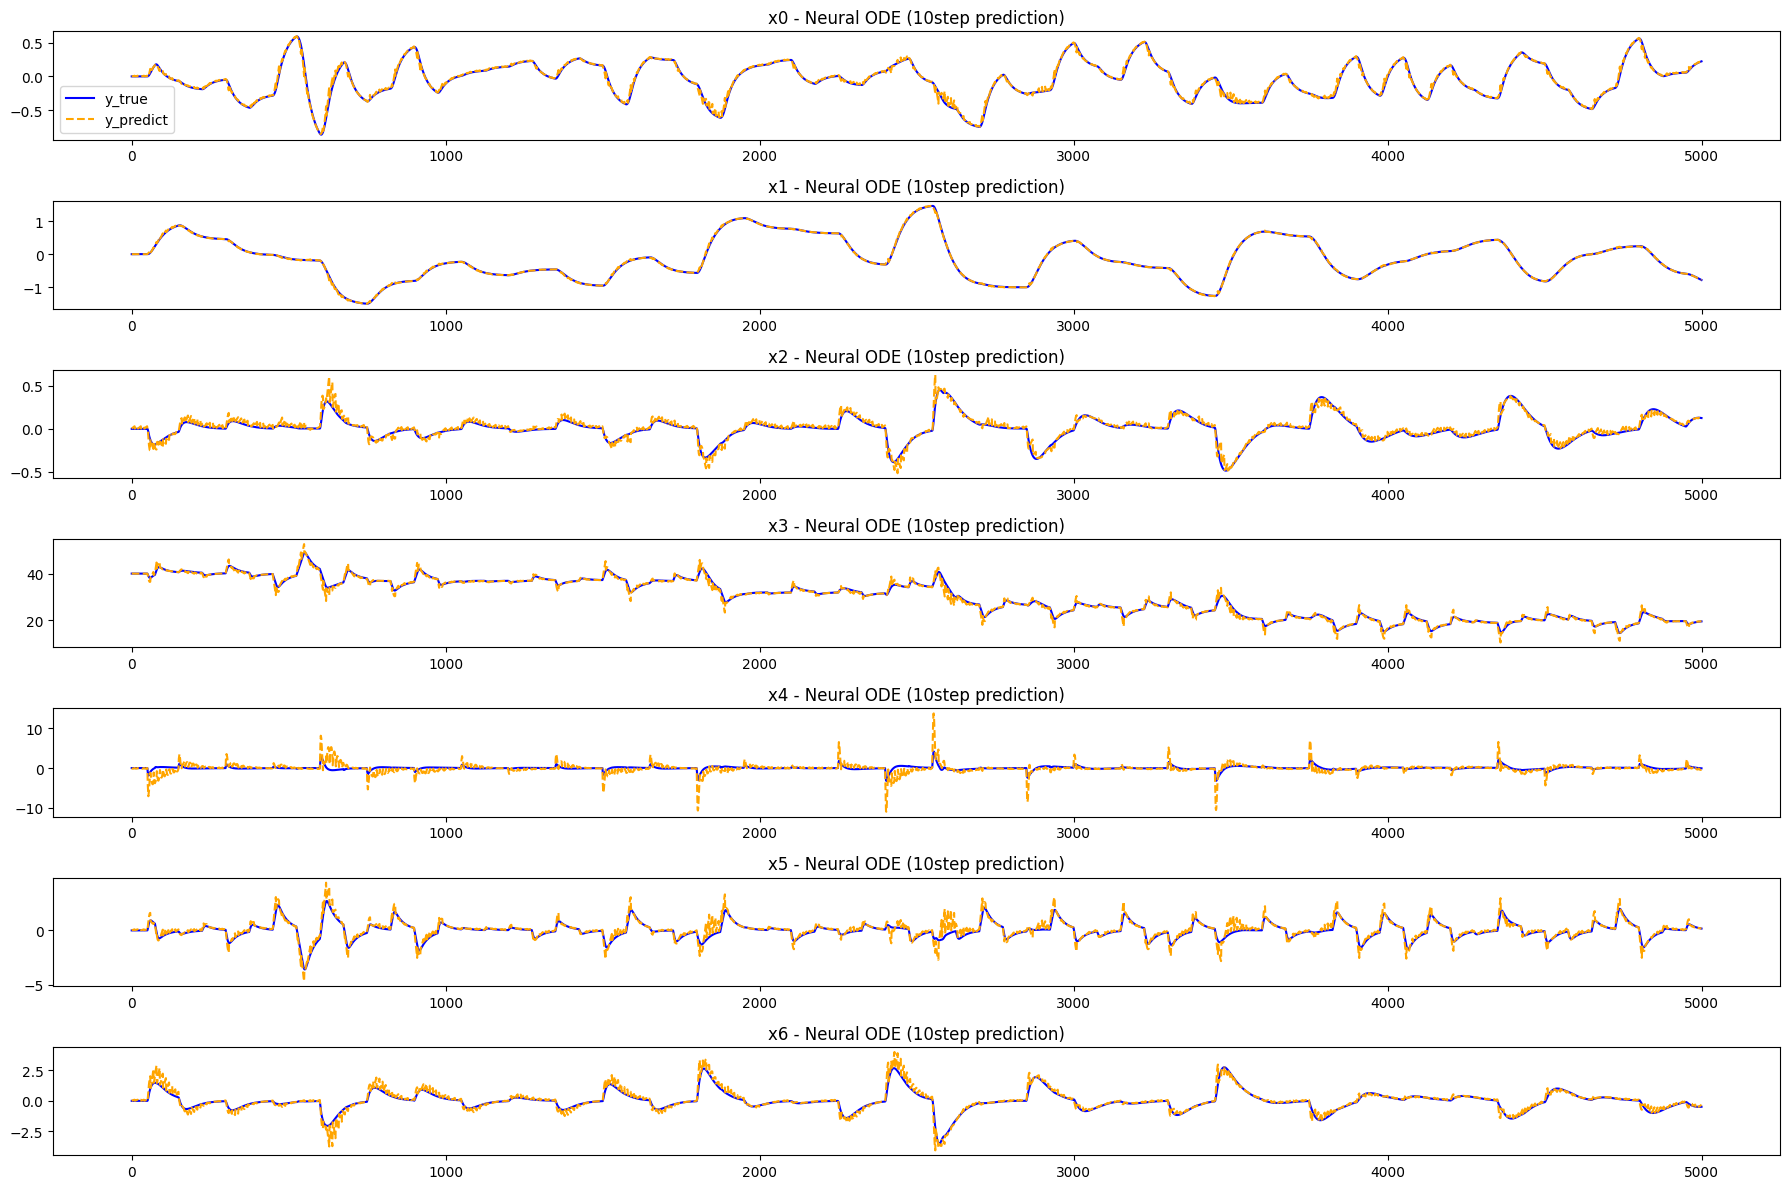

In [ ]:

def evaluate_and_plot(model, test_data, scaler_x, n_steps=1):
    print("\n--- testing  ---")
    model.eval()
    
    x_test, u_test, xp_test = test_data[:]
    x_test, u_test = x_test.to(DEVICE), u_test.to(DEVICE)
    t_span = torch.tensor([0.0, 1.0]).to(DEVICE)

    with torch.no_grad():
        predictions = []
        count = 0
        for x, u, xp in test_data:
            if count == 0 or count% n_steps == 0:
                current_x = x.to(DEVICE).unsqueeze(0) 
            u_t       = u.to(DEVICE).unsqueeze(0)
            predicted_x = model(current_x, u_t, t_span)
            predictions.append(predicted_x.cpu().numpy())
            current_x = predicted_x 
            count += 1

    predictions = np.concatenate(predictions, axis=0)

    preds_rescaled = scaler_x.inverse_transform(predictions)
    #preds_rescaled = apply_kalman_filter(preds_rescaled, Q=1e-3, R=1e-3)
    true_rescaled = scaler_x.inverse_transform(xp_test.numpy())
    
    mse = ((preds_rescaled - true_rescaled) ** 2).mean()
    print(f"\n[Neural ODE] {n_steps} step recursion prediction MSE = {mse:.6e}")

 
    inital_step = 0
    # for i in range(10):
    low = inital_step
    high = inital_step+5000
    plt.figure(figsize=(18, 12))
    for i in range(N_X_FEATURES):
        plt.subplot(N_X_FEATURES, 1, i + 1)
        plt.plot(true_rescaled[low:high, i], label="y_true", color='blue')
        plt.plot(preds_rescaled[low:high, i], "--", label="y_predict", color='orange')
        plt.title(f"x{i} - Neural ODE ({n_steps}step prediction)")
        if i == 0: plt.legend()
    plt.tight_layout()
    plt.show()
    inital_step += 100

HIDDEN_DIM = 256
LEARNING_RATE = 1e-4
EPOCHS = 100

dynamics = ODEDynamics(N_X_FEATURES, N_U_FEATURES, HIDDEN_DIM).to(DEVICE)
neural_ode_model = NeuralODE(dynamics).to(DEVICE)

neural_ode_model.load_state_dict(torch.load("NeuralODE_best.pth", map_location=DEVICE))
evaluate_and_plot(neural_ode_model, test_dataset, scaler_x, n_steps=10)


In [ ]:
N_X_FEATURES = 7
N_U_FEATURES = 2
HIDDEN_DIM = 256
from scipy.io import savemat

dynamics = ODEDynamics(N_X_FEATURES, N_U_FEATURES, HIDDEN_DIM)
neural_ode_model = NeuralODE(dynamics)

# Load the entire model's state dictionary
state_dict = torch.load("NeuralODE_best.pth", map_location=torch.device('cpu'))
neural_ode_model.load_state_dict(state_dict)
print("Model 'NeuralODE_best.pth' loaded successfully.")

# Step 3: Extract the weights and biases
# The keys in the state_dict correspond to the layers in your nn.Sequential model
# 'dynamics_func.net.0.*' is the first fully connected layer
# 'dynamics_func.net.2.*' is the second fully connected layer
# 'dynamics_func.net.4.*' is the third fully connected layer

params = neural_ode_model.state_dict()

# Note: PyTorch weights are [out_features, in_features]. 
# MATLAB fullyConnectedLayer weights are also [out_features, in_features].
# However, weights from Python linear layers often need to be transposed for MATLAB.
# We will handle this in the MATLAB loading script.
w1 = params['dynamics_func.net.0.weight'].numpy()
b1 = params['dynamics_func.net.0.bias'].numpy()
w2 = params['dynamics_func.net.2.weight'].numpy()
b2 = params['dynamics_func.net.2.bias'].numpy()
w3 = params['dynamics_func.net.4.weight'].numpy()
b3 = params['dynamics_func.net.4.bias'].numpy()

# Step 4: Save the parameters to a .mat file
mat_dict = {
    'fc1_weights': w1, 'fc1_bias': b1,
    'fc2_weights': w2, 'fc2_bias': b2,
    'fc3_weights': w3, 'fc3_bias': b3
}
savemat("exported_weights.mat", mat_dict)
print("Weights have been exported to 'exported_weights.mat'")

Model 'NeuralODE_best.pth' loaded successfully.
Weights have been exported to 'exported_weights.mat'
